<a href="https://colab.research.google.com/github/iyqht/simple-neural-network/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.67MB/s]


In [5]:
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16 * 5 * 5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim = 1)

In [8]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start_time = time.time()

epochs = 5
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b,(X_train, y_train) in enumerate(train_loader):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr = (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')

Training took: 3.7466229160626727 minutes!


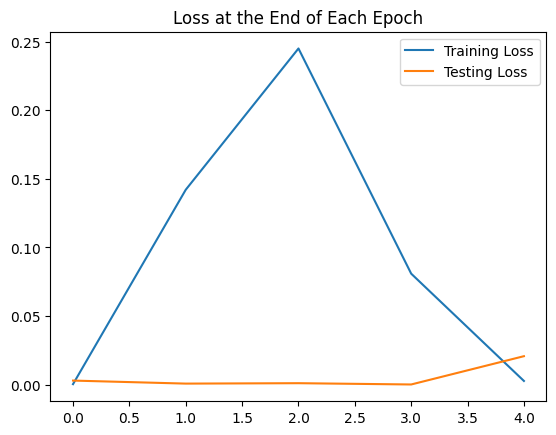

In [12]:
plt.plot([tl.item() for tl in train_losses], label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

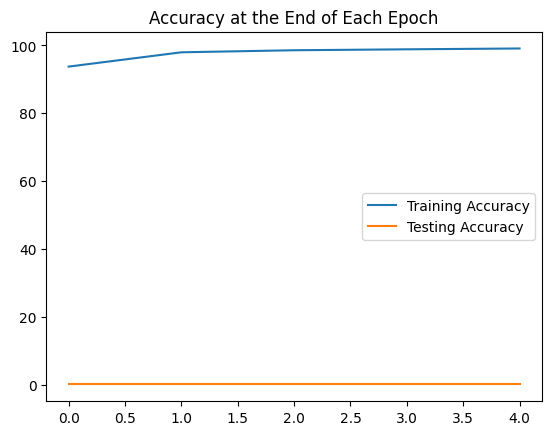

In [13]:
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.legend()

In [14]:
all_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

In [15]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in all_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

print(f'Test Accuracy: {correct.item()/len(test_data)*100}%')

Test Accuracy: 98.57000000000001%
